<a href="https://colab.research.google.com/github/meilinshi/Concept-Drift-Formalization-COSIT-Case-Study/blob/main/COSIT_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity

In [13]:
file_url = 'https://raw.githubusercontent.com/meilinshi/Concept-Drift-Formalization-COSIT-Case-Study/main/Data/cosit_data.csv'

def preprocess(file_url):
    df = pd.read_csv(file_url)
    df['Title'] = df['Title'].str.replace('\n', '')
    df['Keywords'] = df['Keywords'].str.replace(', ', ',')
    df['Year'] = df['Year'].astype(int)

    # Explode the Keywords column to separate each keyword into a separate row
    df['Keywords'] = df['Keywords'].str.lower().str.split(',')
    df_expanded = df.explode('Keywords')
    return df_expanded

df = preprocess(file_url)
df

,Year,Title,Abstract,Keywords
0,1992,Do people understand spatial concepts: The cas...,The purpose of this paper is to examine whethe...,geographic information system
0,1992,Do people understand spatial concepts: The cas...,The purpose of this paper is to examine whethe...,spatial relation
0,1992,Do people understand spatial concepts: The cas...,The purpose of this paper is to examine whethe...,spatial ability
0,1992,Do people understand spatial concepts: The cas...,The purpose of this paper is to examine whethe...,spatial knowledge
1,1992,Temporal databases,"This paper summarizes the major concepts, appr...",query language
...,...,...,...,...
109,2022,Representing Computational Relations in Knowle...,Knowledge representation is the cornerstone of...,spatial relation
109,2022,Representing Computational Relations in Knowle...,Knowledge representation is the cornerstone of...,computational relation
109,2022,Representing Computational Relations in Knowle...,Knowledge representation is the cornerstone of...,functional programming
109,2022,Representing Computational Relations in Knowle...,Knowledge representation is the cornerstone of...,haskell


In [16]:
# get paper count statistics
keyword_counts_by_year = df.groupby('Year').agg(
    unique_title_count=('Title', 'nunique'),
    keyword_count=('Keywords', 'count')
)

# Calculate total paper and keyword count
total_paper_count = keyword_counts_by_year['unique_title_count'].sum()
total_keyword_count = keyword_counts_by_year['keyword_count'].sum()

# Create a new row for the total
total_row = pd.DataFrame({
    'unique_title_count': total_paper_count,
    'keyword_count': total_keyword_count
}, index=['Total'])

pd.concat([keyword_counts_by_year, total_row])

,unique_title_count,keyword_count
1992,25,122
2001,33,171
2011,23,107
2022,29,147
Total,110,547


In [17]:
# get keyword count statistics
keyword_counts = df.groupby(['Keywords']).size().reset_index(name='Count')
keyword_counts = keyword_counts[keyword_counts['Count'] >= 5] #.sort_values(by='Count', ascending=False)
keywords = keyword_counts['Keywords']
keyword_counts

,Keywords,Count
124,geographic information system,7
231,navigation,5
277,qualitative spatial reasoning,6
360,spatial cognition,8
376,spatial knowledge,5
389,spatial reasoning,11


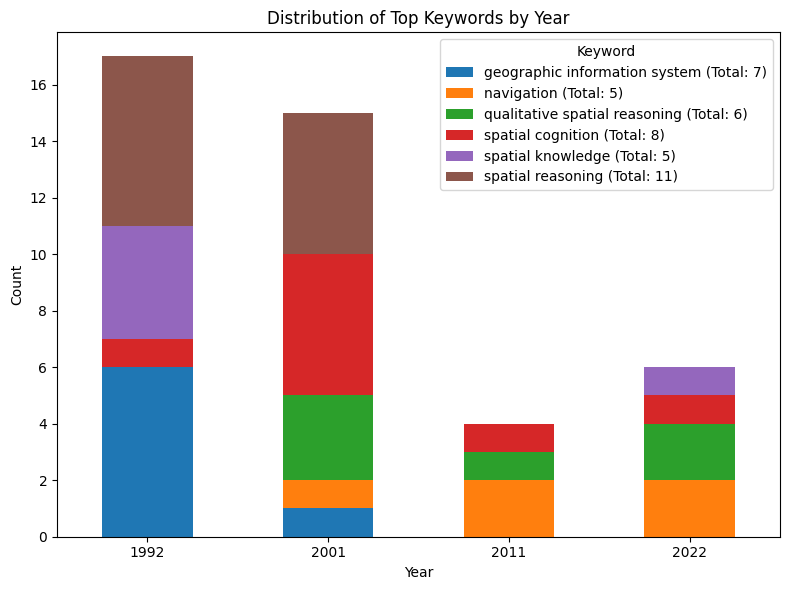

In [18]:
# Figure 1 - Distribution and frequency of top keywords by year

import matplotlib.pyplot as plt
filtered_df = df[df['Keywords'].isin(keywords)]

# Group by year and keyword, then count occurrences
keyword_counts = filtered_df.groupby(['Year', 'Keywords']).size().unstack(fill_value=0)

# Plot distribution
keyword_counts.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.title('Distribution of Top Keywords by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=0)


total_counts = filtered_df['Keywords'].value_counts()

# Create legend with total counts
legend_labels = [f'{keyword} (Total: {total_counts[keyword]})' for keyword in keywords]
plt.legend(legend_labels, title='Keyword')

plt.tight_layout()
plt.show()

In [27]:
# generate contextual embeddings based on paper title and abstract
from tqdm import tqdm

def generate_keyword_embeddings(df):

    # Load the pretrained SciBERT tokenizer and model
    tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
    model = BertModel.from_pretrained("allenai/scibert_scivocab_uncased")

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Group the DataFrame by 'year' and 'keyword', and aggregate 'title' and 'abstract'
    grouped_df = df.groupby(['Year', 'Keywords']).agg({'Title': ' '.join, 'Abstract': ' '.join}).reset_index()

    # Create a list to store dictionaries for each year, keyword, and embedding
    rows = []

    # Iterate through each group
    batch_size = 16
    for i in tqdm(range(0, len(grouped_df), batch_size)):
        batch = grouped_df.iloc[i:i+batch_size]
        texts = (batch['Title'] + ' ' + batch['Abstract']).tolist()

        # Tokenize the batch of texts
        tokens = tokenizer(texts, add_special_tokens=True, truncation=True, max_length=512, padding=True, return_tensors="pt")

        # Move tokens to GPU if available
        tokens = {key: val.to(device) for key, val in tokens.items()}

        # Generate embeddings for the tokens using SciBERT model
        with torch.no_grad():
            outputs = model(**tokens)
            embedding = outputs[0][:, 0, :].cpu().numpy()

        # Append a dictionary with year, keyword, and embedding to the list
        for j, row in batch.iterrows():
          rows.append({'Year': row['Year'], 'Keyword': row['Keywords'], 'Embedding': embedding[j % batch_size]})

    # Create a DataFrame from the list of dictionaries
    embeddings_df = pd.DataFrame(rows)

    return embeddings_df

In [28]:
embeddings = generate_keyword_embeddings(df)
embeddings

100%|██████████| 31/31 [00:11<00:00,  2.67it/s]


,Year,Keyword,Embedding
0,1992,adjacent triangle,"[0.062276453, 0.15055174, 0.27586812, -0.88408..."
1,1992,automatic learning,"[-0.27870247, 0.29294795, -0.98471117, -0.0032..."
2,1992,average farm size,"[0.015622576, 0.31561896, -0.20980087, 0.07175..."
3,1992,boundary edge,"[0.062276453, 0.15055174, 0.27586812, -0.88408..."
4,1992,boundary segment,"[-0.1432975, -0.3568437, 0.6535974, 0.19310935..."
...,...,...,...
491,2022,urban traffic system,"[-0.074444704, 0.40415984, -0.7762525, 0.49603..."
492,2022,view,"[0.13998921, 0.03812292, 0.17644429, -0.516666..."
493,2022,viewpoint,"[0.13998921, 0.03812292, 0.17644429, -0.516666..."
494,2022,volumetric space,"[-0.03572511, 0.010299448, 0.6397596, 0.547316..."


In [29]:
#generate textual embeddings for the keywords

def generate_textual_embeddings(df, batch_size=16):

    # Load the pretrained SciBERT tokenizer and model
    tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
    model = BertModel.from_pretrained("allenai/scibert_scivocab_uncased")

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Define a function to generate textual embeddings
    def generate_embedding(text):

        # Tokenize input texts
        inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True, padding=True)

        # Move inputs to GPU if available
        inputs = {key: val.to(device) for key, val in inputs.items()}

        # Forward pass through the model
        with torch.no_grad():
            outputs = model(**inputs)

        # Extract the output embeddings
        embedding = outputs.last_hidden_state.mean(dim=1).cpu().numpy()

        return embedding

    # Split the data into batches and process each batch
    embeddings = []
    for i in tqdm(range(0, len(df), batch_size), desc="Generating textual embeddings"):
        batch_texts = df['Keyword'].iloc[i:i+batch_size].tolist()
        batch_embeddings = generate_embedding(batch_texts)
        embeddings.extend(batch_embeddings)

    # Add the embeddings to the DataFrame
    df['Textual_embedding'] = embeddings

    return df

In [30]:
embeddings_agg = generate_textual_embeddings(embeddings)
embeddings_agg

Generating textual embeddings: 100%|██████████| 31/31 [00:00<00:00, 69.50it/s]


,Year,Keyword,Embedding,Textual_embedding
0,1992,adjacent triangle,"[0.062276453, 0.15055174, 0.27586812, -0.88408...","[0.31820828, 0.6052479, -0.2931582, -0.3431202..."
1,1992,automatic learning,"[-0.27870247, 0.29294795, -0.98471117, -0.0032...","[-0.6769086, 0.7327209, 0.20150736, -0.7877456..."
2,1992,average farm size,"[0.015622576, 0.31561896, -0.20980087, 0.07175...","[-0.580655, 0.44115752, -0.60075635, 0.0496279..."
3,1992,boundary edge,"[0.062276453, 0.15055174, 0.27586812, -0.88408...","[0.5769189, 1.182175, -0.8344613, -0.4693494, ..."
4,1992,boundary segment,"[-0.1432975, -0.3568437, 0.6535974, 0.19310935...","[0.40891856, 0.7607957, -0.6940677, -0.3915126..."
...,...,...,...,...
491,2022,urban traffic system,"[-0.074444704, 0.40415984, -0.7762525, 0.49603...","[-0.72710335, -0.030349102, -0.0593575, -0.083..."
492,2022,view,"[0.13998921, 0.03812292, 0.17644429, -0.516666...","[0.09858802, 0.1419392, -0.79206026, -0.647268..."
493,2022,viewpoint,"[0.13998921, 0.03812292, 0.17644429, -0.516666...","[0.26282743, 0.91471595, -0.72254014, -0.69092..."
494,2022,volumetric space,"[-0.03572511, 0.010299448, 0.6397596, 0.547316...","[0.6799784, 0.5859094, -0.01700522, -0.994629,..."


In [31]:
# list the most frequent keywords

keyword_counts = embeddings_agg['Keyword'].value_counts()
keyword_counts[:15]

,count
Keyword,
spatial cognition,4
navigation,3
spatial information,3
qualitative spatial reasoning,3
landmarks,2
object,2
spatial descriptions,2
map interpretation,2
geographic information system,2


In [32]:
# for one keyword
target_keyword = 'spatial reasoning'
filtered_df = embeddings_agg[(embeddings_agg['Keyword'] == target_keyword) & (embeddings_agg['Year'] == 1992)]
filtered_df

,Year,Keyword,Embedding,Textual_embedding
76,1992,spatial reasoning,"[-0.36508355, -0.5465949, 0.05441944, 0.509414...","[-0.7944361, 0.2903502, 0.4152807, -0.7102696,..."


In [43]:
def filter_by_year(df, year):
  df = df[df['Year'] == year]
  return df

In [44]:
df_1992 = filter_by_year(embeddings_agg, 1992)
df_2001 = filter_by_year(embeddings_agg, 2001)
df_2011 = filter_by_year(embeddings_agg, 2011)
df_2022 = filter_by_year(embeddings_agg, 2022)

In [45]:
# compute cosine similarity between embeddings
from sklearn.preprocessing import normalize

def compute_similarity_matrix(df1, df2):
    """
    Compute pairwise cosine similarity matrix between embeddings of keywords from two dataframes.

    Args:
    - df1: DataFrame containing keywords and embeddings for year 1
    - df2: DataFrame containing keywords and embeddings for year 2

    Returns:
    - similarity_matrix: Pairwise cosine similarity matrix
    """
    # Extract embeddings from dataframes
    embeddings_1 = np.array(df1['textual_embedding'].tolist())
    embeddings_2 = np.array(df2['textual_embedding'].tolist())

    # Compute pairwise cosine similarity
    similarity_matrix = cosine_similarity(embeddings_1, embeddings_2)

    return similarity_matrix

In [51]:
def normalize_embedding(df):

    # Extract embeddings and convert to NumPy array
    embeddings = np.array(df['Embedding'].tolist())
    t_embeddings = np.array(df['Textual_embedding'].tolist())

    # Normalize the embeddings
    normalized_embeddings = normalize(embeddings)
    normalized_t_embeddings = normalize(t_embeddings)

    # Create a new DataFrame with the normalized embeddings
    df_normalized = df.copy()
    df_normalized['Embedding'] = normalized_embeddings.tolist()
    df_normalized['Textual_embedding'] = normalized_t_embeddings.tolist()

    return df_normalized

In [52]:
df_keyword = filtered_df._append(df_2022)
df_keyword = normalize_embedding(df_keyword)
df_keyword

,Year,Keyword,Embedding,Textual_embedding
76,1992,spatial reasoning,"[-0.0158520620316267, -0.02373335137963295, 0....","[-0.036167118698358536, 0.013218345120549202, ..."
357,2022,3d,"[0.01104709692299366, -0.005689956247806549, -...","[0.03527269512414932, 0.05326399579644203, 0.0..."
358,2022,3d space,"[-0.0015581330517306924, 0.0004492510342970490...","[0.01447239052504301, 0.015759844332933426, 0...."
359,2022,abstraction,"[0.01104709692299366, -0.005689956247806549, -...","[0.05630210414528847, 0.08225405216217041, -0...."
360,2022,acceptance model,"[-0.014551332220435143, -0.03120397962629795, ...","[0.007319102995097637, 0.023376014083623886, -..."
...,...,...,...,...
491,2022,urban traffic system,"[-0.0032869977876544, 0.017845090478658676, -0...","[-0.03328103572130203, -0.0013891416601836681,..."
492,2022,view,"[0.006205263547599316, 0.0016898640897125006, ...","[0.004318871535360813, 0.006217967718839645, -..."
493,2022,viewpoint,"[0.006205263547599316, 0.0016898640897125006, ...","[0.011663878336548805, 0.04059369117021561, -0..."
494,2022,volumetric space,"[-0.001558105112053454, 0.00044919727952219546...","[0.031478848308324814, 0.027124030515551567, -..."


In [54]:
# Apply the function to compute the similarity score and sort descending

# target keyword contextual and textual embedding
target_embedding_context = df_keyword['Embedding'].iloc[0]
target_embedding_text = df_keyword['Textual_embedding'].iloc[0]

# Calculate cosine similarity between target keyword embedding and all other embeddings
similarities_context = cosine_similarity([target_embedding_context], df_keyword['Embedding'].tolist())[0]
similarities_text = cosine_similarity([target_embedding_text], df_keyword['Textual_embedding'].tolist())[0]
overall_similarities = 0.8*similarities_context + 0.2*similarities_text

# Save similarities as a new column in the DataFrame
df_keyword['Similarity_to_' + target_keyword] = overall_similarities
df_sorted = df_keyword.sort_values(by='Similarity_to_' + target_keyword, ascending=False)
split_ex = df_sorted[:25]
split_ex

,Year,Keyword,Embedding,Textual_embedding,Similarity_to_spatial reasoning
76,1992,spatial reasoning,"[-0.0158520620316267, -0.02373335137963295, 0....","[-0.036167118698358536, 0.013218345120549202, ...",1.000000
422,2022,machine learning,"[0.039885807782411575, -0.013330869376659393, ...","[0.008373822085559368, 0.04396798834204674, -0...",0.814431
434,2022,navigation,"[0.013087274506688118, 0.005516261328011751, -...","[0.015456942841410637, 0.020489422604441643, 0...",0.811601
468,2022,spatial analysis,"[0.010798218660056591, 0.00033365131821483374,...","[0.00462768180295825, 0.005211494863033295, 0....",0.811152
495,2022,wayfnding,"[0.017804738134145737, -0.007184872403740883, ...","[-0.022716723382472992, 0.05386980623006821, -...",0.810085
448,2022,qualitative spatial reasoning,"[0.04155256226658821, -0.0076814373023808, -0....","[-0.048452842980623245, 0.03762289881706238, -...",0.809931
402,2022,geospatial prepositions,"[0.0420999750494957, -0.00997462309896946, -0....","[-0.008893778547644615, 0.017077339813113213, ...",0.798255
369,2022,cognitive geoengineering,"[0.0016907667741179466, 0.03041018359363079, -...","[0.0026448494754731655, 0.026218706741929054, ...",0.791597
435,2022,navigation support systems,"[0.0016907667741179466, 0.03041018359363079, -...","[-0.022311745211482048, 0.022206127643585205, ...",0.791531
404,2022,giscience theory,"[0.017027076333761215, -0.010176993906497955, ...","[0.023810265585780144, 0.02937745489180088, -0...",0.774722


In [55]:
target_embedding_text = split_ex['Textual_embedding'].iloc[0]

# Calculate cosine similarity between target keyword embedding and all other embeddings
similarities_text = cosine_similarity([target_embedding_text], split_ex['Textual_embedding'].tolist())[0]
split_ex['Similarity_to_' + target_keyword] = similarities_text
split_ex = split_ex.sort_values(by='Similarity_to_' + target_keyword, ascending=False)
split_ex

<ipython-input-55-64ec563c671f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  split_ex['Similarity_to_' + target_keyword] = similarities_text


,Year,Keyword,Embedding,Textual_embedding,Similarity_to_spatial reasoning
76,1992,spatial reasoning,"[-0.0158520620316267, -0.02373335137963295, 0....","[-0.036167118698358536, 0.013218345120549202, ...",1.000000
448,2022,qualitative spatial reasoning,"[0.04155256226658821, -0.0076814373023808, -0....","[-0.048452842980623245, 0.03762289881706238, -...",0.923542
477,2022,spatial learning,"[0.018182791769504547, -0.018985379487276077, ...","[-0.017799213528633118, 0.01026422530412674, 0...",0.914416
469,2022,spatial cognition,"[-0.0015581330517306924, 0.0004492510342970490...","[-0.03128177672624588, -8.606071787653491e-05,...",0.898714
478,2022,spatial navigation,"[-0.0154695650562644, -0.003193620126694441, -...","[0.009087378159165382, 0.005539403297007084, 0...",0.871723
450,2022,qualitative temporal reasoning,"[0.03037380799651146, 0.004032510798424482, -0...","[-0.030035028234124184, 0.04130315035581589, -...",0.860439
404,2022,giscience theory,"[0.017027076333761215, -0.010176993906497955, ...","[0.023810265585780144, 0.02937745489180088, -0...",0.831383
402,2022,geospatial prepositions,"[0.0420999750494957, -0.00997462309896946, -0....","[-0.008893778547644615, 0.017077339813113213, ...",0.807416
369,2022,cognitive geoengineering,"[0.0016907667741179466, 0.03041018359363079, -...","[0.0026448494754731655, 0.026218706741929054, ...",0.803880
435,2022,navigation support systems,"[0.0016907667741179466, 0.03041018359363079, -...","[-0.022311745211482048, 0.022206127643585205, ...",0.803548
